--- Note: Using default example path for 'folder_to_analyze'. Ensure this is correct. ---
Processing files in '../Analysis/game_trajectories/Cramped Room/' for episodes 1-20...

--- Averaged Statistics & Distance Plots (Max Timesteps: 404) ---

=== Pair: Human Keyboard Input vs Self-Play (based on 20 episodes) ===
  Pair-Level Average Stats:
    Avg. Total Reward: 16.00
    Avg. Soups Delivered: 0.80
    Avg. Reward Efficiency: 0.04
    Avg. Conflict Count: 0.15
    Avg. Avg Reaction Time Pair: 0.00
  Average Stats for Human Keyboard Input (in this pair):
    Avg. Interact: 0.55
    Avg. Idle: 395.70
    Avg. Entropy: 0.15
    Avg. Deliveries: 0.10
  Average Stats for Self-Play (in this pair):
    Avg. Interact: 54.35
    Avg. Idle: 1.00
    Avg. Entropy: 1.91
    Avg. Deliveries: 0.70
  Displaying average distance plot for: Human Keyboard Input vs Self-Play


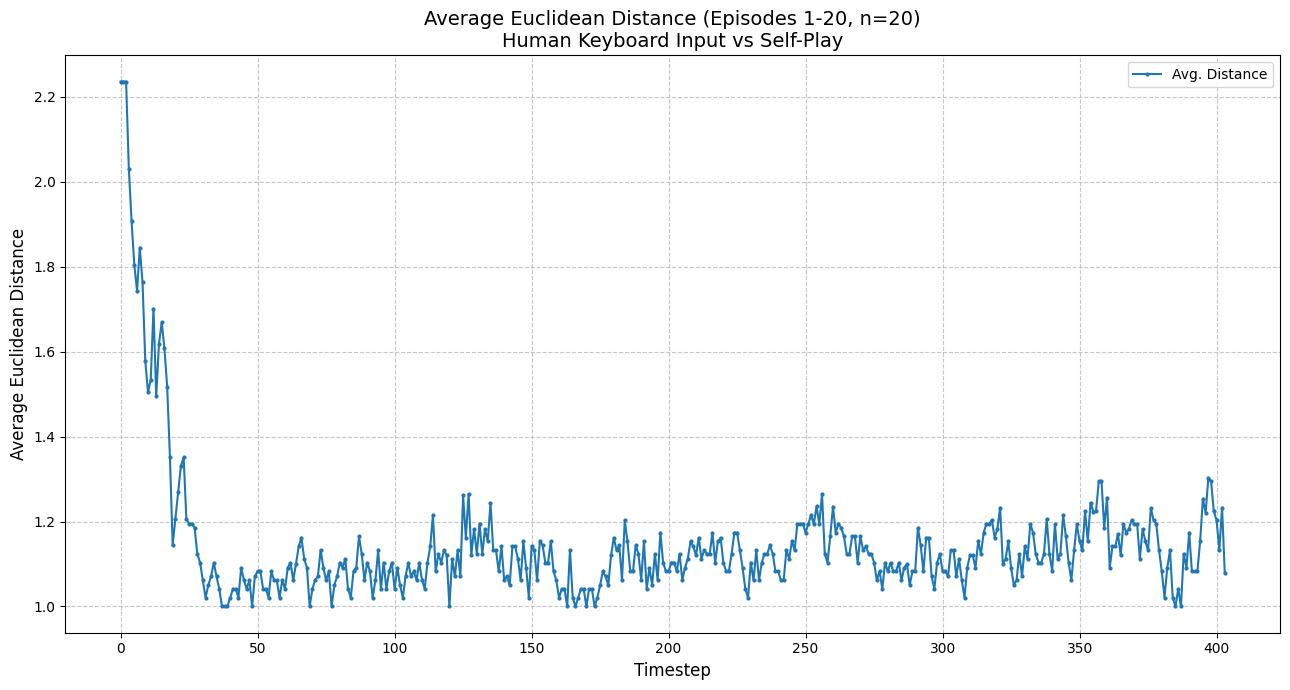


=== Pair: Human-aware PPO vs Self-Play (based on 20 episodes) ===
  Pair-Level Average Stats:
    Avg. Total Reward: 182.00
    Avg. Soups Delivered: 9.10
    Avg. Reward Efficiency: 0.45
    Avg. Conflict Count: 29.35
    Avg. Avg Reaction Time Pair: 0.00
  Average Stats for Human-aware PPO (in this pair):
    Avg. Interact: 100.70
    Avg. Idle: 62.05
    Avg. Entropy: 2.48
    Avg. Deliveries: 4.75
  Average Stats for Self-Play (in this pair):
    Avg. Interact: 169.20
    Avg. Idle: 1.20
    Avg. Entropy: 2.06
    Avg. Deliveries: 4.35
  Displaying average distance plot for: Human-aware PPO vs Self-Play


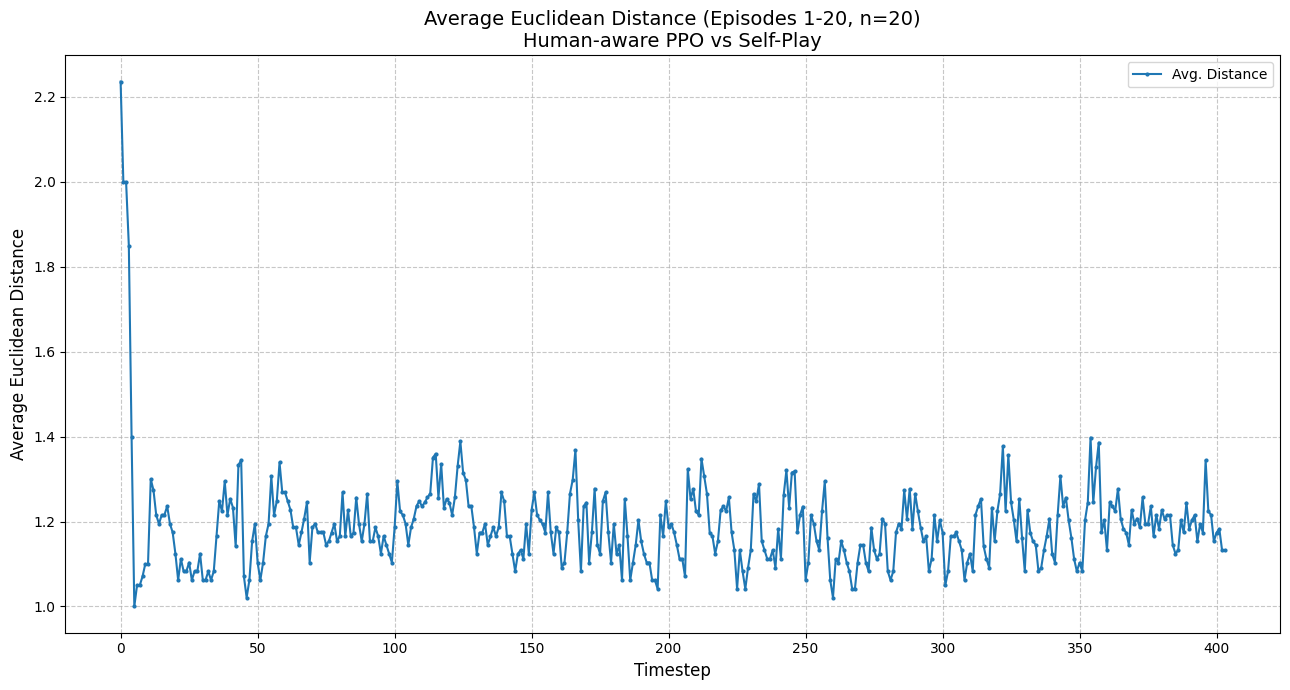


=== Pair: Population-Based Training vs Self-Play (based on 20 episodes) ===
  Pair-Level Average Stats:
    Avg. Total Reward: 149.00
    Avg. Soups Delivered: 7.45
    Avg. Reward Efficiency: 0.37
    Avg. Conflict Count: 41.95
    Avg. Avg Reaction Time Pair: 0.00
  Average Stats for Population-Based Training (in this pair):
    Avg. Interact: 91.00
    Avg. Idle: 23.45
    Avg. Entropy: 2.42
    Avg. Deliveries: 4.50
  Average Stats for Self-Play (in this pair):
    Avg. Interact: 140.95
    Avg. Idle: 1.20
    Avg. Entropy: 2.14
    Avg. Deliveries: 2.95
  Displaying average distance plot for: Population-Based Training vs Self-Play


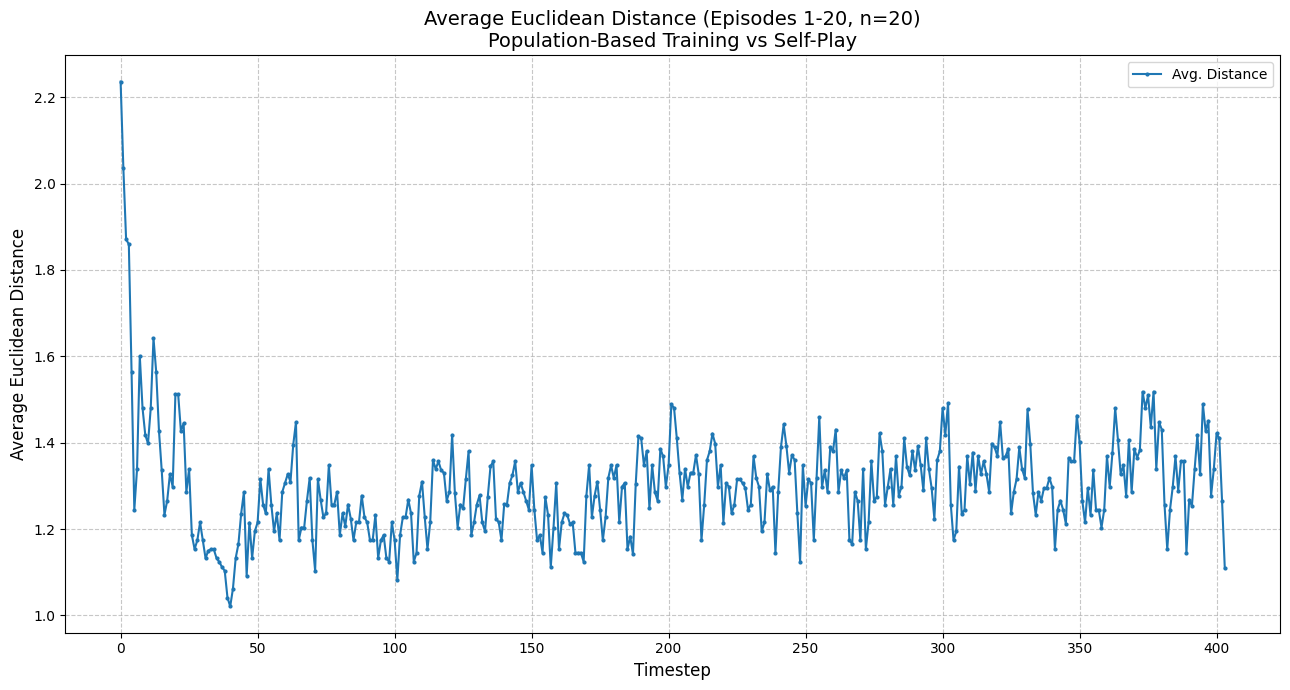


=== Pair: Self-Play vs Self-Play (based on 20 episodes) ===
  Pair-Level Average Stats:
    Avg. Total Reward: 172.00
    Avg. Soups Delivered: 8.60
    Avg. Reward Efficiency: 0.43
    Avg. Conflict Count: 101.80
    Avg. Avg Reaction Time Pair: 0.00
  Average Stats for Self-Play (in this pair):
    Avg. Interact: 184.70
    Avg. Idle: 1.40
    Avg. Entropy: 1.99
    Avg. Deliveries: 4.55
  Average Stats for Self-Play (in this pair):
    Avg. Interact: 185.90
    Avg. Idle: 1.30
    Avg. Entropy: 1.97
    Avg. Deliveries: 4.05
  Displaying average distance plot for: Self-Play vs Self-Play


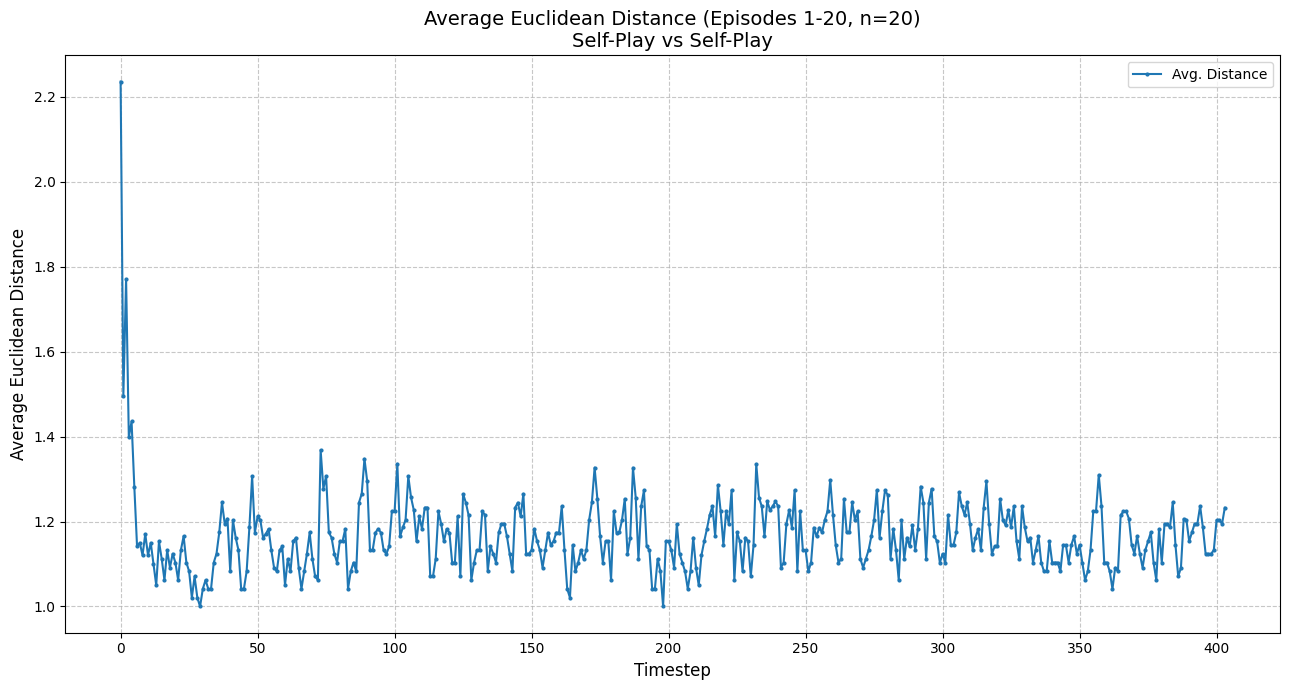

In [16]:
import os
import json
import math
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import re

ALL_AGENT_NAMES = sorted([
    "Human-aware PPO",
    "Population-Based Training",
    "Self-Play",
    "Human Keyboard Input"
])

def compute_entropy(action_list):
    if not action_list:
        return 0.0
    counts = Counter(str(a) for a in action_list)
    total = sum(counts.values())
    if total == 0:
        return 0.0
    return -sum((c / total) * math.log(c / total, 2) for c in counts.values() if c > 0)

def detect_coordination_conflicts(observations, actions):
    conflict_count = 0
    max_len = min(len(observations), len(actions))
    for t in range(1, max_len):
        if len(observations[t].get("players", [])) < 2 or \
           observations[t]["players"][0] is None or \
           observations[t]["players"][1] is None or \
           observations[t]["players"][0].get("position") is None or \
           observations[t]["players"][1].get("position") is None:
            continue
        pos0 = tuple(observations[t]["players"][0]["position"])
        pos1 = tuple(observations[t]["players"][1]["position"])
        if t >= len(actions) or len(actions[t]) < 2:
            continue
        act0 = actions[t][0]
        act1 = actions[t][1]
        both_interact = (act0 == "INTERACT" or (isinstance(act0, list) and "INTERACT" in act0)) and \
                        (act1 == "INTERACT" or (isinstance(act1, list) and "INTERACT" in act1))
        near_same_tile = abs(pos0[0] - pos1[0]) + abs(pos0[1] - pos1[1]) <= 1
        if both_interact and near_same_tile:
            conflict_count += 1
    return conflict_count

def parse_filename_for_agents_and_episode(filename):
    match = re.match(r"^(.*?) vs (.*?) .*\((\d+)\)\.json$", filename)
    if match:
        agent1_name = match.group(1).strip()
        agent2_name = match.group(2).strip()
        episode_number = int(match.group(3))
        if agent1_name in ALL_AGENT_NAMES and agent2_name in ALL_AGENT_NAMES:
            return agent1_name, agent2_name, episode_number
    return None

def get_stats_and_distance_series_from_json_file(filepath, agent1_name_from_filename, agent2_name_from_filename):
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
    except Exception:
        return None

    if not data.get('ep_observations') or not data['ep_observations'][0]: return None
    observations = data['ep_observations'][0]
    episode_length = len(observations)
    if episode_length == 0: return None

    actions = data.get('ep_actions', [[]])[0] if data.get('ep_actions') else [[] for _ in range(episode_length)]
    rewards = data.get('ep_rewards', [[]])[0] if data.get('ep_rewards') else [0 for _ in range(episode_length)]

    if len(actions) < episode_length: actions.extend([[] for _ in range(episode_length - len(actions))])
    if len(rewards) < episode_length: rewards.extend([0 for _ in range(episode_length - len(rewards))])

    if not (observations[0].get("players") and len(observations[0].get("players")) == 2): return None

    distance_series = [None] * episode_length
    interact_counts = [0, 0]
    idle_counts = [0, 0]
    action_sequences = [[], []]
    
    for t in range(episode_length):
        current_players_in_obs = observations[t].get("players", [])
        if len(current_players_in_obs) == 2:
            p0_data = current_players_in_obs[0]
            p1_data = current_players_in_obs[1]
            if p0_data and p0_data.get("position") and p1_data and p1_data.get("position"):
                pos0, pos1 = tuple(p0_data["position"]), tuple(p1_data["position"])
                distance_series[t] = math.sqrt((pos0[0] - pos1[0])**2 + (pos0[1] - pos1[1])**2)
            
            if t < len(actions) and len(actions[t]) == 2:
                for i in [0, 1]:
                    act = actions[t][i]
                    action_sequences[i].append(act)
                    if act == "INTERACT" or (isinstance(act, list) and "INTERACT" in act):
                        interact_counts[i] += 1
                    elif act == [0, 0] or act == (0,0): # Handle list or tuple for idle
                        idle_counts[i] += 1
        
    total_reward = sum(rewards)
    soups_delivered = rewards.count(20)
    reward_efficiency = total_reward / episode_length if episode_length > 0 else 0
    entropies = [compute_entropy(seq) for seq in action_sequences]
    conflict_count = detect_coordination_conflicts(observations, actions)

    division_of_labor = [0, 0]
    reaction_times_list = []
    reward_events = [(i, r) for i, r in enumerate(rewards) if r > 0]
    credited_rewards_for_dol = set()

    for t_reward, r_value in reward_events:
        if r_value == 20 and t_reward not in credited_rewards_for_dol:
            found_deliverer_for_event = False
            for dt in range(3):
                check_t = t_reward - dt
                if not (0 <= check_t < len(observations)): continue
                obs_players_at_check_t = observations[check_t].get("players", [])
                if len(obs_players_at_check_t) < 2: continue
                for agent_idx_in_json in [0, 1]:
                    player_data = obs_players_at_check_t[agent_idx_in_json]
                    if player_data and player_data.get("held_object", {}).get("name") == "soup":
                        division_of_labor[agent_idx_in_json] += 1
                        reaction_times_list.append(dt)
                        credited_rewards_for_dol.add(t_reward)
                        found_deliverer_for_event = True
                        break 
                if found_deliverer_for_event: break
    
    avg_reaction_time = sum(reaction_times_list) / len(reaction_times_list) if reaction_times_list else None

    return {
        "distance_series": distance_series,
        "agent1_name_in_file": agent1_name_from_filename,
        "agent2_name_in_file": agent2_name_from_filename,
        "total_reward": total_reward,
        "soups_delivered": soups_delivered,
        "reward_efficiency": reward_efficiency,
        "conflict_count": conflict_count,
        "avg_reaction_time_pair": avg_reaction_time,
        "interact_p0": interact_counts[0], "idle_p0": idle_counts[0], 
        "entropy_p0": entropies[0], "deliveries_p0": division_of_labor[0],
        "interact_p1": interact_counts[1], "idle_p1": idle_counts[1], 
        "entropy_p1": entropies[1], "deliveries_p1": division_of_labor[1],
    }

def analyze_and_plot_average_stats_and_distances(folder_path, episodes_to_average=range(1, 21)):
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The specified folder does not exist: {folder_path}")

    all_filenames_in_folder = os.listdir(folder_path)
    if not all_filenames_in_folder:
        print(f"No files found in folder: {folder_path}")
        return

    print(f"Processing files in '{folder_path}' for episodes {min(episodes_to_average)}-{max(episodes_to_average)}...")
    aggregated_pair_episode_data = defaultdict(list)
    max_overall_timesteps = 0
    processed_file_count = 0

    for filename in all_filenames_in_folder:
        if not filename.endswith(".json"): continue
        parsed_info = parse_filename_for_agents_and_episode(filename)
        if parsed_info:
            agent1_name, agent2_name, episode_number = parsed_info
            if episode_number in episodes_to_average:
                processed_file_count += 1
                filepath = os.path.join(folder_path, filename)
                stats_and_series = get_stats_and_distance_series_from_json_file(filepath, agent1_name, agent2_name)
                if stats_and_series:
                    canonical_pair_key = tuple(sorted((agent1_name, agent2_name)))
                    aggregated_pair_episode_data[canonical_pair_key].append(stats_and_series)
                    max_overall_timesteps = max(max_overall_timesteps, len(stats_and_series["distance_series"]))
    
    if processed_file_count == 0:
        print(f"No files matching criteria were processed.")
        return
    if not aggregated_pair_episode_data:
        print("No data successfully aggregated. Cannot generate reports or plots.")
        return

    print(f"\n--- Averaged Statistics & Distance Plots (Max Timesteps: {max_overall_timesteps}) ---")

    for canonical_pair, episode_data_list in aggregated_pair_episode_data.items():
        N1_name, N2_name = canonical_pair
        num_episodes_for_this_pair = len(episode_data_list)
        print(f"\n=== Pair: {N1_name} vs {N2_name} (based on {num_episodes_for_this_pair} episodes) ===")

        pair_level_stats_aggr = defaultdict(list)
        N1_stats_aggr = defaultdict(list)
        N2_stats_aggr = defaultdict(list)
        all_distance_series_for_pair = []

        for ep_data in episode_data_list:
            all_distance_series_for_pair.append(ep_data["distance_series"])
            pair_level_stats_aggr["total_reward"].append(ep_data["total_reward"])
            pair_level_stats_aggr["soups_delivered"].append(ep_data["soups_delivered"])
            pair_level_stats_aggr["reward_efficiency"].append(ep_data["reward_efficiency"])
            pair_level_stats_aggr["conflict_count"].append(ep_data["conflict_count"])
            if ep_data["avg_reaction_time_pair"] is not None:
                pair_level_stats_aggr["avg_reaction_time_pair"].append(ep_data["avg_reaction_time_pair"])

            current_file_agent1 = ep_data["agent1_name_in_file"]
            if current_file_agent1 == N1_name: # P0 was N1, P1 was N2
                N1_stats_aggr["interact"].append(ep_data["interact_p0"])
                N1_stats_aggr["idle"].append(ep_data["idle_p0"])
                N1_stats_aggr["entropy"].append(ep_data["entropy_p0"])
                N1_stats_aggr["deliveries"].append(ep_data["deliveries_p0"])
                N2_stats_aggr["interact"].append(ep_data["interact_p1"])
                N2_stats_aggr["idle"].append(ep_data["idle_p1"])
                N2_stats_aggr["entropy"].append(ep_data["entropy_p1"])
                N2_stats_aggr["deliveries"].append(ep_data["deliveries_p1"])
            else: # P0 was N2, P1 was N1
                N2_stats_aggr["interact"].append(ep_data["interact_p0"])
                N2_stats_aggr["idle"].append(ep_data["idle_p0"])
                N2_stats_aggr["entropy"].append(ep_data["entropy_p0"])
                N2_stats_aggr["deliveries"].append(ep_data["deliveries_p0"])
                N1_stats_aggr["interact"].append(ep_data["interact_p1"])
                N1_stats_aggr["idle"].append(ep_data["idle_p1"])
                N1_stats_aggr["entropy"].append(ep_data["entropy_p1"])
                N1_stats_aggr["deliveries"].append(ep_data["deliveries_p1"])
        
        print("  Pair-Level Average Stats:")
        for stat_name, values in pair_level_stats_aggr.items():
            avg_val = sum(values) / len(values) if values else 0
            print(f"    Avg. {stat_name.replace('_', ' ').title()}: {avg_val:.2f}")

        for agent_name_in_pair, agent_stats_aggr in [(N1_name, N1_stats_aggr), (N2_name, N2_stats_aggr)]:
            print(f"  Average Stats for {agent_name_in_pair} (in this pair):")
            for stat_name, values in agent_stats_aggr.items():
                avg_val = sum(values) / len(values) if values else 0
                print(f"    Avg. {stat_name.replace('_', ' ').title()}: {avg_val:.2f}")
        
        padded_series_list = []
        for s in all_distance_series_for_pair:
            new_s = [np.nan] * max_overall_timesteps
            for i in range(min(len(s), max_overall_timesteps)):
                if s[i] is not None: new_s[i] = s[i]
            padded_series_list.append(new_s)
        
        if not padded_series_list: continue
        try:
            averaged_distances = np.nanmean(np.array(padded_series_list), axis=0)
        except Exception: averaged_distances = np.array([np.nan] * max_overall_timesteps)

        plot_timesteps = np.arange(max_overall_timesteps)
        valid_indices = ~np.isnan(averaged_distances)
        plot_timesteps_valid, plot_values_valid = plot_timesteps[valid_indices], averaged_distances[valid_indices]

        if len(plot_values_valid) > 0:
            plt.figure(figsize=(13, 7))
            plt.plot(plot_timesteps_valid, plot_values_valid, marker='.', linestyle='-', markersize=4, label=f"Avg. Distance")
            plt.title(f"Average Euclidean Distance (Episodes {min(episodes_to_average)}-{max(episodes_to_average)}, n={num_episodes_for_this_pair})\n{N1_name} vs {N2_name}", fontsize=14)
            plt.xlabel("Timestep", fontsize=12)
            plt.ylabel("Average Euclidean Distance", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            plt.tight_layout()
            print(f"  Displaying average distance plot for: {N1_name} vs {N2_name}")
            plt.show()
        else:
            print(f"  No valid averaged distance data to plot for pair: {N1_name} vs {N2_name}.")

folder_to_analyze = "../Analysis/game_trajectories/Cramped Room/" 
if folder_to_analyze == "../Analysis/game_trajectories/Cramped Room/":
    print("--- Note: Using default example path for 'folder_to_analyze'. Ensure this is correct. ---")

try:
    analyze_and_plot_average_stats_and_distances(folder_to_analyze, episodes_to_average=range(1, 21))
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")